# 🚀 ResuMeme.AI : Your Gemini-Powered Resume Report & Meme Generator

---

## 🎯 The Problem

It's 2025. You've got the skills. You've got the resume.  
But let’s be honest:

🔹 Your formatting is a little chaotic.  
🔹 Your skills section is... *everywhere.*  
🔹 The ATS scanner? Still confused.   
🔹 Randomly applying to all jobs that come in sight.

Meanwhile, GenAI is already shaping how candidates are evaluated — from formatting to tone to meme-ability.

---

## 💡 The Idea

**ResuMeme.AI** is your AI-powered resume coach & vibe check buddy — built entirely with **Gemini APIs + Python** inside Kaggle.

You give:
- 📄 Your resume

CareerCraft gives back:
- ✅ A full resume analysis (strengths, gaps, score)
- 📊 ATS compliance and formatting evaluation
- 💼 Matched jobs and missing skills (from a real search!)
- 📄 A clean, stylish **PDF report**
- 🖼 A custom **GenAI-generated meme**
- 📝 The meme caption — rendered in bold
- 📝 Tell me about yourself pitch

---


## ⚙️ How It Works (Behind the Scenes)
1. **📋 Resume Analysis**
   - Comprehensive scoring system evaluates each resume section
   - Detailed feedback with specific improvement suggestions
   - ATS compliance checks for both content and visual formatting
   - Automatic entity mapping extracts skills, experience, and qualifications
   
2. **💼 Job Matching**
   - Matches resume against potential job opportunities
   - Calculates match percentages based on skill alignment
   - Identifies missing skills needed for target roles
   - Prioritizes jobs by match quality

3. **🖨️ PDF Generation**
   - WeasyPrint creates a clean, emoji-rich PDF card with all insights
   - Custom styling with clear section organization
   - Color-coded match percentages and ATS verdicts
   - Comprehensive yet scannable format

4. **💡 Meme Generation**
   - Gemini analyzes resume strengths and career story
   - Creates a custom meme caption that captures career highlights
   - Generates a relevant image that complements the caption
   - Combines text and visual for shareable career celebration

5. **🎯 Interview Preparation**
   - Generates personalized "Tell me about yourself" responses
   - Based on actual resume content and achievements
   - Conversational tone with proper structure and emphasis
   - Ready to use in real interview situations
---

## ✨ Why This Notebook is Cool
- **Zero manual input** — it's all dictionary-driven + GenAI-powered
- **Looks professional** — emoji-friendly PDF with clean styling
- **Feels personal** — all outputs reflect your *specific* resume and career
- **End-to-end Gemini** — from analysis to visualization to meme generation
- **Actionable insights** — not just criticism, but concrete suggestions
- **Interview-ready** — prepares you for the next step after resume submission
---

## ✅ GenAI Techniques Used


| Capability                             | Implementation Details |
|----------------------------------------|-------------------------|
| **Structured Output / JSON Mode**      | Used Gemini’s JSON mode to return structured resume feedback in consistent, typed formats |
| **Few-shot Prompting**                 | Implemented Chain-of-Thought prompts with examples to guide Gemini’s resume evaluation |
| **Document Understanding**             | Resume PDF is parsed, chunked, and passed to Gemini for both surface-level and deep critique |
| **Function Calling**                   | Used `google.generativeai.types.FunctionDeclaration` to define custom tools for Gemini |
| **Embeddings**                         | Created job description and resume embeddings for semantic matching and scoring |
| **Retrieval-Augmented Generation (RAG)**| Retrieved relevant job descriptions using SERP API and grounded Gemini responses in real-time search results |
| **Grounding**                          | All outputs are tied to structured resume dictionary (no freeform hallucinations) |
| **Image Understanding**                | Simulated vision-based ATS decision with image placeholder, future-ready for Gemini Vision API |
| **Vector Search / Vector Store**       | Stored and compared resume-job similarity scores using cosine similarity with embeddings |
| **HTML + Markdown Rendering**          | Rich PDF generation and meme captioning with Gemini outputs styled for visual readability |
---

### 🚀 Ready to turn your resume into a story + a laugh?

Run the notebook and enjoy the journey.

*Built in Kaggle. Powered by Gemini. Styled by your chaos.*


### Install the packages

In [1]:
!pip install -U -q "google-genai==1.7.0"
!pip install -qU "chromadb==0.6.3"
!pip install PyMuPDF
!pip install PyPDF2
# !pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install python-docx fpdf
!pip install google-search-results
!pip install weasyprint

### Import packages

In [2]:
import PIL.Image
import requests
from bs4 import BeautifulSoup
from google import genai
from google.genai import types
from IPython.display import HTML, Markdown, display
from pdf2image import convert_from_path
import typing_extensions as typing
import fitz  # PyMuPDF
from IPython.display import Image
from PIL import Image
import os
from typing import Annotated
from typing_extensions import TypedDict
from chromadb import Documents, EmbeddingFunction, Embeddings
from IPython.display import Markdown
from typing import TypedDict, List, Literal

print(genai.__version__)
from google.api_core import retry
import pandas as pd
from IPython.display import display
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})


1.7.0


### Authenticate Gemini client

In [3]:
from kaggle_secrets import UserSecretsClient

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
## This will be our final score for the person's career artifacts
career_scorecard = {}

# Resume Analysis

## 📄 Reading the Resume PDF

This notebook works with a single resume document uploaded as a dataset. We first need to extract the text content from the PDF for analysis.

**Input Source:**
- Resume PDF located at: `/kaggle/input/anu-resume/Anupama Garani Sheshagiri Resume.docx.pdf`
- This is the only input required for the entire analysis pipeline

**What the code does:**
- Reads all pages of the PDF document using PyPDF2
- Extracts text content while preserving information
- Cleans the text by removing carriage returns and extra whitespace
- Returns both the cleaned text and page count for reference

**Why this matters:**
PDF extraction is a critical first step since all our GenAI analysis depends on clean, properly formatted text. The quality of our resume evaluation is directly tied to how well we handle this initial document processing.

In [5]:
# Import required libraries
import os
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from IPython.display import display, HTML, Image
# import google.generativeai as genai

print("Libraries imported successfully!")

def read_pdf_text(file_path):
    num_pages=0
    full_path = os.path.join("/kaggle/input", file_path)
    
    # Let's store the contents in text string
    text = ""
    with open(full_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        num_pages=len(pdf_reader.pages)
        for page in pdf_reader.pages:
            text += page.extract_text()
    
    if not text.strip():
        print("Warning: No text extracted from PDF!")
    else:
        print(f"Successfully read PDF - extracted {len(text)} characters")
    cleaned = text.replace('\n', ' ').replace('  ', ' ')
    return cleaned.strip(),num_pages
    

# Call the function to read pdf
resume_text,pno = read_pdf_text("anu-resume/Anupama Garani Sheshagiri Resume.docx.pdf")
resume_text[:2000]
pno

Libraries imported successfully!
Successfully read PDF - extracted 8893 characters


2

### Zero-Shot Resume Analysis 🎯

In this step, we see the power of Gemini to analyze resumes without any examples or specific formatting instructions.

**What's happening here:**
- We're using a simple prompt that positions Gemini as a professional resume critic
- No examples are provided (zero-shot approach) to test Gemini's baseline understanding
- The model identifies formatting issues, content problems, and provides practical fixes
- This demonstrates Gemini's built-in knowledge of resume best practices and standards

This technique showcases how well Gemini understands document structure and professional norms without explicit guidance, allowing us to get immediate feedback before applying more advanced techniques.

The function below takes a cleaned resume text and returns a comprehensive analysis:

In [6]:
def zero_shot_prompt(resume_text_cleaned):
    resume_prompt = f"""
    You are ResumeCritic, a world-class GenAI career agent. Show all the errors with the resume.
    Also fix each section
    Resume:
    \"\"\"
    {resume_text_cleaned}
    \"\"\"
    """
    
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=resume_prompt)

    return response.text

zero_shot_response = zero_shot_prompt(resume_text)
career_scorecard['zero_shot_feedback']=zero_shot_response
Markdown(zero_shot_response)


Okay, I've reviewed your resume. It has strong content demonstrating your skills and experience, but it needs significant formatting and structural improvements to be more effective and ATS-friendly. Here's a breakdown of the errors and a revised version with explanations:

**General Errors and Improvements Needed:**

*   **Formatting:** The resume is riddled with inconsistent spacing, unusual character usage, and poor formatting choices. This makes it visually unappealing and difficult to read.
*   **ATS Compatibility:** The unusual spacing and formatting will likely cause problems with Applicant Tracking Systems (ATS). ATS are used by most companies to scan resumes, and if your resume isn't formatted correctly, it might be rejected automatically.
*   **Clarity and Conciseness:** Some descriptions are wordy and could be more impactful by using stronger action verbs and quantifying accomplishments.
*   **Chronological Order:** Ensure all experiences are listed in reverse chronological order (most recent first).
*   **Inconsistent Dates:** Date formatting is inconsistent. Use a standard format (e.g., MM/YYYY).
*   **Typos and Grammar:** There are minor typos and grammatical issues.
*   **"Skills and Interests" Section:** This is outdated. Focus on skills that are directly relevant to the jobs you are applying for.
*   **Redundant Information:** Some skills are repeated across different sections.
*   **Lack of Emphasis:** Important achievements aren't always highlighted effectively.
*   **Unnecessary Information:** The full addresses of previous employers are not usually required. City, State is sufficient.
*   **Inconsistent Verb Tense:** Use consistent verb tenses (past tense for previous roles, present tense for current roles).

**Revised Resume:**

```
Anupama Garani
(313) 502-8478 | anupamagarani95@gmail.com | Austin, TX | linkedin.com/in/anupama-garani | github.com/anusky95

**Summary**

Data Science professional with experience in transforming data into actionable insights that drive business growth. Proficient in data analysis, machine learning, and data visualization. Seeking a challenging role where I can leverage my skills to contribute to a data-driven organization.

**Skills**

*   **Programming Languages:** Python, SQL, JavaScript
*   **Data Science & Machine Learning:** Machine Learning Algorithms, NumPy, Pandas, NLTK, scikit-learn
*   **Data Visualization:** Tableau, Microsoft Power BI
*   **Databases:** Snowflake, SQL Server, MongoDB
*   **Cloud Computing:** Microsoft Azure
*   **Other Tools:** Alteryx, Git, JIRA, HTML, CSS, XML, MS Excel, MS PowerPoint

**Education**

*   **Rochester Institute of Technology, Rochester, NY**
    *   Master of Science in Information Science & Technology, Data Analysis | August 2016 - August 2019 | GPA: 3.4
    *   Relevant Coursework: Python, Machine Learning, Statistics, Visual Analytics, Data Warehouse, Data Mining, Database Development
    *   *Thesis: Automating the Creativity Prediction in Requirement Engineering (NLP, ML, SQL, Python)*
    *   Awarded Graduate Assistantship and 80% Scholarship (2017-2018)

*   **Udacity, Online**
    *   Bertelsmann Data Science Challenge Scholarship Nanodegree | December 2018
    *   Relevant Coursework: Descriptive Statistics, SQL, Python, Tableau, Excel, Data Visualization
    *   Certificate: [https://confirm.udacity.com/9K7CLLKN](https://confirm.udacity.com/9K7CLLKN)

*   **PES Institute of Technology, Bangalore, India**
    *   Bachelor of Engineering in Computer Science | August 2012 - July 2016
    *   Relevant Coursework: Database Development & Management System, Unix & Shell Programming

**Experience**

*   **Pacific Investment Management Company (PIMCO), Austin, TX**
    *   **Client Data Specialist, Technology** | June 2021 - Present
    *   Optimize data delivery pipeline by automating report generation, quality checks, and vendor communication.
    *   Develop bots to reduce manual tasks for publishing assets, transaction data, and KPI metrics to Slack channels.
    *   Develop multiple Data Quality Automation checks for proactive issue monitoring in the data pipeline.
    *   Lead the migration of Python codebase from Oracle to Snowflake.
    *   *Skills: Python, SQL, JSON, Snowflake*

*   **Goldman Sachs Ayco Personal Financial Management, Cohoes, NY**
    *   **Operations Analyst, Business Intelligence** | September 2019 - June 2021
    *   Designed an OCR solution by automating text extraction from PDF, achieving 0.7 headcount savings.
    *   Forecasted headcount and resources required using polynomial linear regression, resulting in 0.5 headcount savings.
    *   Aggregated approximately 95M client's private wealth-related data and published dashboards in Tableau for senior management.
    *   Developed an end-to-end Machine Learning Model for recommending investment strategies to clients.
    *   Designed multiple interactive Tableau dashboards to visualize business processes, capacity models, and projected growth.
    *   Coordinated with stakeholders to identify business requirements and presented projects and dashboards to senior management.
    *   *Skills: Alteryx (certified), Python, SQL, Tableau, Project Management, Machine Learning, Presentation Skills, Excel*

*   **Rochester Institute of Technology, Assessment Technology & Communication - Division of Student Affairs, Rochester, NY**
    *   **Graduate Assistant, Data Analyst (Part-Time)** | February 2019 - August 2019
    *   Conducted hypothesis testing and tests of significance to validate student performance improvement on tests.
    *   Conducted regression analysis and correlation for student department data to analyze the relationship between strategies and outcomes.
    *   Published visualizations incorporating guided analytics techniques using Tableau for various student affairs departments.
    *   Gathered requirements and coordinated with administrative staff for feedback and improvement of visualizations.
    *   *Skills: Tableau, Data Visualization, Reporting, Microsoft PowerPoint, Python, Statistics*

*   **eHealth Technologies, West Henrietta, NY**
    *   **Research and Software Development Intern (Internship)** | May 2018 - December 2018
    *   Delivered quality code for server-side and user interface of software utilizing the Agile process.
    *   Developed and implemented the core functionality of applications using NodeJS for backend and MongoDB (MEAN stack).
    *   Participated as a SCRUM member in brainstorming solutions to enhance software quality through testing and feedback.
    *   Enhanced application quality by incorporating application insights using Microsoft Azure.
    *   Collaborated in entering and updating issues into JIRA and code documentation in Atlassian Confluence.
    *   *Skills: Microsoft Azure, NodeJS, MongoDB, JIRA, Unit Testing, Technical Documentation*

*   **Rochester Institute of Technology, Rochester, NY**
    *   **Graduate Assistant, Application Developer (Part-Time)** | August 2017 - May 2018
    *   Developed an interactive and dynamic web application for creating American Sign Language from Natural Language.
    *   Collaborated with interaction designers and brainstormed UI mockups and wireframes.
    *   Achieved pixel-perfection while designing the application to match the desired prototype.
    *   *Skills: Agile Methodology, Software Development, HTML5, CSS, JavaScript, UI/UX Design*

*   **Rochester Institute of Technology, Rochester, NY**
    *   **Research Assistant, Data Analysis - NLP and Machine Learning (Part-Time)** | June 2017 - August 2018
    *   Implemented supervised learning algorithms for document classification (decision trees, SVM, Naive Bayes, Logistic Regression) using NLTK, scikit-learn, and Pandas in Python.
    *   Applied clustering and topic modeling processes (LDA, HLDA, MALLET) to analyze the quality of crowdsourced requirements.
    *   Improved the efficiency of the requirement engineering process by automating the process up to 50%.
    *   Automated data aggregation by scraping e-commerce websites for product details.
    *   *Skills: SQL, Python, NumPy, Machine Learning, Web Scraping, Data Mining, Natural Language Processing*

```

**Key Changes and Explanations:**

*   **Contact Information:** Cleaned up formatting, removed unnecessary address details.
*   **Summary:** Replaced the vague introductory statement with a concise and targeted summary. This is a critical section for grabbing the recruiter's attention.
*   **Skills Section:**  Reorganized into categories for better readability. Focuses on hard skills relevant to data science roles.  Removed "interests."
*   **Education Section:** Standardized date formats, added thesis title, and made descriptions concise.
*   **Experience Section:**
    *   Used strong action verbs at the start of each bullet point (e.g., "Developed," "Designed," "Implemented").
    *   Quantified accomplishments whenever possible (e.g., "Achieved 0.7 headcount savings").
    *   Focused on the impact of your work.
    *   Used consistent verb tense (past tense).
    *   Removed full addresses.
    *   Added a *Skills* subsection to each work experience, to highlight the tools used in each job.
*   **Formatting:**  Consistent use of bolding, spacing, and bullet points.
*   **Removed Redundancy:** Skills are primarily listed in the Skills section and then reinforced within the experience descriptions.
*   **ATS Optimization:**  Used standard headings and formatting that ATS systems can easily parse.

**Next Steps:**

1.  **Tailor to Each Job:**  Customize the skills and experience sections to match the specific requirements of each job you apply for.  Prioritize the most relevant information.
2.  **Proofread Carefully:**  Have someone else proofread your resume to catch any remaining errors.
3.  **Use a Professional Template:** Consider using a clean and modern resume template from a reputable source (e.g., Microsoft Word, Canva, or a dedicated resume builder).  Make sure the template is ATS-compatible.
4.  **Save as PDF:**  Always save your resume as a PDF to preserve the formatting.

By implementing these changes, your resume will be more visually appealing, easier to read, and more likely to pass through ATS systems, significantly increasing your chances of landing an interview. Good luck!


## 🧠 Resume Entity Mapping with Function Calling

This section demonstrates **structured output generation** using Gemini's function calling capabilities. Instead of free-form text responses, we guide the model to extract specific resume entities in a structured JSON format.

**What this does:**
- Defines a precise schema for resume information extraction
- Uses `GenerateContentConfig` with function declarations to enforce structure
- Processes the entire resume to extract key parameters:
  - Location, experience, skills, education
  - Target job titles and seniority level
  - Professional summary and bullet points
  - Tools grouped by category (Programming, Cloud, ML, etc.)

**Benefits of this approach:**
- Guarantees consistent data structure for downstream processing
- Reduces hallucinations by constraining the model output
- Creates a clean, normalized representation of resume data
- Enables more reliable job matching and analysis

The extracted entity map becomes the foundation for our entire analysis pipeline, ensuring all subsequent steps work with standardized resume data.

In [7]:
def extract_resume_details(resume_text):
 # Define the function declaration for the model
 resume_mapping_function = {
     "name": "resume_mapping",
     "description": "Extracts the parameters such as location, experience, skills, degree, job type from the resume supplied",
     "parameters": {
         "type": "object",
         "properties": {
             "location": {
                 "type": "string",
                 "description": "Location mentioned in the resume",
             },
             "experience": {
                 "type": "array",
                 "items": {"type": "string"},
                 "description": "List of experiences the resume lists. Example: Intern, Mid, Advanced, Director",
             },
             "skills": {
                 "type": "array",
                 "items": {"type": "string"},
                 "description": "List of skills mentioned in the resume. Example: Python, R, SQL",
             },
             "degree": {
                 "type": "array",
                 "items": {"type": "string"},
                 "description": "List of degrees mentioned in the resume. Example: Associate, Bachelors, Masters, PhD, Pursuing degree, High school",
             },
             "job_type": {
                 "type": "array",
                 "items": {"type": "string"},
                 "description": "List of job type the job seeker is looking for.Default to Full-Time if nothing is provided. Example: Full-time, Part-time, Temporary, Internship",
             },
             "target_job_title":{
                 "type": "array",
                 "items": {"type": "string"},
                 "description": "Based on the resume, infer 1–2 realistic and industry-standard job titles the candidate is best suited for (e.g., 'Data Scientist', 'ML Engineer', 'BI Analyst'). Avoid vague phrases like 'data science professional.Example: Software engineer, data analyst, data scientist",
             },
             "summary_text": {
              "type": "string",
              "description": "Extracted professional summary section from the resume"
            },
            "bullet_points": {
              "type": "array",
              "items": {"type": "string"},
              "description": "List of bullet points from the experience section"
            },
            "projects": {
              "type": "array",
              "items": {"type": "string"},
              "description": "Projects described in the resume"
            },
            "certifications": {
              "type": "array",
              "items": {"type": "string"},
              "description": "Professional certifications like Google Cloud, Tableau, etc."
            },
            "tools_grouped": {
              "type": "object",
              "properties": {
                "Programming": {"type": "array", "items": {"type": "string"}},
                "Cloud": {"type": "array", "items": {"type": "string"}},
                "ML": {"type": "array", "items": {"type": "string"}},
                "Databases": {"type": "array", "items": {"type": "string"}},
                "Other": {"type": "array", "items": {"type": "string"}}
              },
              "description": "Grouped tools by type"
            },
            "seniority_level": {
              "type": "string",
              "enum": ["Intern", "Entry", "Mid", "Senior", "Director"],
              "description": "Inferred seniority level based on resume"
            }
            
                    },
         "required": ["location",
            "experience",
            "skills",
            "degree",
            "job_type",
            "target_job_title",
            "summary_text",
            "bullet_points",
            "projects",
            "certifications",
            "tools_grouped",
            "seniority_level"],
     },
 }

 tools = types.Tool(function_declarations=[resume_mapping_function])
 config = types.GenerateContentConfig(tools=[tools])

 # Send request with function declarations
 response = client.models.generate_content(
     model="gemini-2.0-flash",
     contents=resume_text,
     config=config,
 )

 # Check for a function call
 if response.candidates[0].content.parts[0].function_call:
     function_call = response.candidates[0].content.parts[0].function_call
     return function_call.args
     
 else:
     print("No function call found in the response.")
     print(response.text)
     return None


resume_entities_mapped = extract_resume_details(resume_text)
print(json.dumps(resume_entities_mapped, indent=2))
career_scorecard['resume_entity_mapped']=resume_entities_mapped

{
  "location": "Austin,  Texas",
  "bullet_points": [
    "Optimized  data  delivery  pipeline  by  automating  the  report  generation,  quality  checks  &  communication  to  the  vendors.",
    "Developed  bots  thereby  reducing  the  dependency  of  manual  tasks  for  publishing  assets  &  transaction  data  &  KPI  metrics  to  Slack  channels.",
    "Developed  multiple  Data  Quality  Automation  checks  for  proactive  monitoring  of  issues  in  the  data  pipeline",
    "Leaded  the  migration  of  python  codebase  from  Oracle  to  Snowflake",
    "Designed  an  OCR  solution  by  automating  text  extraction  from  PDF  capable  of  achieving  0.7  Headcount  and  financial  savings.",
    "Achieved  0.5  headcount  savings  by  forecasting  headcount  and  resources  required  to  handle  the  projected  volume  of  work  using  Polynomial  linear  regression.",
    "Aggregated  approx  95M  client\u2019s  private  wealth  related  data  and  published  dashboards  in

## 📊 Resume Critic Agent: Structured Analysis with JSON Schema

This section demonstrates **structured output generation** and **few-shot prompting** in action. We've created a sophisticated resume evaluation system that applies industry best practices to each section of the resume.

**How it works:**
- Defines a strongly-typed schema using Python's `TypedDict` for consistent evaluation
- Implements a comprehensive prompt with detailed scoring criteria for each resume section
- Provides both positive and negative examples to guide the model's evaluation
- Uses Gemini's structured JSON output capability for consistent, machine-readable responses
- Evaluates multiple aspects with specific feedback and improvement suggestions:
  - Summary (conciseness, keywords, metrics)
  - Experience bullet points (STAR format, metrics, impact)
  - Skills (organization, relevance, clustering)
  - Tools (categorization, proficiency levels)
  - Projects (business impact, specificity, links)

**Benefits of this approach:**
- Produces consistent, quantified feedback across all resume sections
- Concrete, actionable suggestions rather than vague advice
- Few-shot examples dramatically improve evaluation quality
- JSON output enables immediate integration with our scorecard generation

The resulting evaluation becomes the foundation of our career scorecard, providing a data-driven analysis of the resume's strengths and weaknesses.

In [8]:
class SectionScore(typing.TypedDict):
    score: float
    feedback: List[str]
    updates: List[str]

class ResumeEvaluation(typing.TypedDict):
    summary: SectionScore
    experience: SectionScore
    skills: SectionScore
    tools: SectionScore
    projects: SectionScore
    overall_score: float
    seniority_match: Literal["Under-leveled", "Proper", "Over-leveled"]

def resume_critic_agent(resume_text,summary_text, bullet_points, skills, target_job_title, tools_grouped, projects, job_type):
    
    resume_critic_prompt = f"""
    You are ResumeCritic, a GenAI resume evaluation agent trained to think step-by-step.
    
    You will evaluate a candidate's resume, structured into sections:
    - Summary
    - Bullet Points
    - Skills (based on target job title)
    - Tools (based on target job title)
    - Projects
    - Job Type
    - Target Title
    ---
    
    🧪 For each section, think step by step and follow this process:
    1. Carefully read the provided content
    2. Apply the scoring rules and best practices 
    3. Compare against the positive and negative examples
    4. Provide a final score (1-10) for the section
    5. Give specific feedback - identify exact lines needing improvement and explain why
    6. Suggest concrete updates for each issue identified
    
    Be thorough in your analysis and detailed in your feedback.
    
    ---
    
    🎯 Scoring Rules:

    Based on the best practices for summary, 
    - **Summary**
      - +2 if under 3 lines with 5+ job-aligned keywords
      - -1 for buzzwords like "passionate", "dynamic"
      - Best Practice: "Keep it factual, job-targeted, and metric-aligned"
      - Keep it to 1 line summary 

      ✅ GOOD EXAMPLES:
      - "ML engineer with 5+ years experience building recommendation systems that increased revenue by 23% across SaaS platforms."
      - "Data scientist specializing in NLP, predictive modeling, and A/B testing with proven 35% accuracy improvements for Fortune 500 clients."
      - "Machine learning developer who reduced customer churn by 18% using clustering, Python, and AWS at scale for fintech applications."
      - "Results-driven data engineer leveraging Spark, Airflow, and SQL to process 5TB daily data, enabling 40% faster decision-making."
      - "Analytics specialist with expertise in TensorFlow, scikit-learn, and dashboard creation that increased marketing ROI by 27%."

      ❌ BAD EXAMPLES:
      - "Passionate data scientist with a dynamic approach to solving complex business problems and a proven track record of success."
      - "Hardworking and detail-oriented data professional seeking to leverage my skills and knowledge in a challenging role with opportunity for growth."
      - "Innovative and creative thinker with extensive experience in data analysis and a strong background in mathematics and statistics, eager to make an impact."
      - "Team player with excellent communication skills who is passionate about data science and machine learning, looking for new opportunities."
      - "Detail-oriented data scientist with experience in Python, R, and data analysis with strong analytical and problem-solving skills."
      
      evaluate {summary_text}

    Based on the best practices for experience bullet points, 
    - **Experience Bullet Points**
      - +2 per bullet with metrics ($, %, time saved)
      - -1.5 for "responsible for", "helped with"
      - Best Practice: "Use Verb + Metric + Result format (STAR)"
      
      ✅ GOOD EXAMPLES:
      - "Developed automated anomaly detection model that reduced fraud by 42% ($3.2M annually) while decreasing false positives by 18%."
      - "Streamlined ETL processes by implementing Airflow, reducing daily processing time from 6 hours to 45 minutes and saving $120K in compute costs."
      - "Created customer segmentation algorithm that identified 3 new target markets, leading to $1.8M in additional revenue over 6 months."
      - "Built and deployed production ML pipeline using Kubernetes that scaled to process 300M daily transactions with 99.99% uptime."
      - "Designed A/B testing framework that accelerated experiment velocity by 200%, enabling 40+ tests per month versus previous 12."

      ❌ BAD EXAMPLES:
      - "Responsible for data analysis and reporting for the marketing team."
      - "Helped with the development of machine learning models to improve business outcomes."
      - "Worked on data cleaning and preprocessing to support analytics initiatives within the organization."
      - "Participated in weekly meetings to discuss project progress and collaborated with team members on various tasks."
      - "Assisted senior data scientists with implementing various machine learning algorithms for customer analysis."
      
      evaluate {bullet_points}
      
    Based on the best practices for skills, 
    - **Skills**
      - +3 for well-clustered skills
      - -2 for outdated or unrelated tech
      - Best Practice: "Cluster into Programming, ML, Cloud, Data Viz"
      
      ✅ GOOD EXAMPLES:
      - Example 1:
        **Programming:** Python (Expert), R (Intermediate), SQL (Expert), Java (Basic)
        **Libraries:** NumPy, Pandas, scikit-learn, TensorFlow, PyTorch, Keras
        **Machine Learning:** Random Forest, XGBoost, LSTM, CNN, Transformers, BERT
        **Techniques:** Feature Engineering, Transfer Learning, Hyperparameter Tuning
        **Cloud & Big Data:** AWS (Certified), Google Cloud, Spark, Hadoop, Airflow, Kafka
        **Data Visualization:** Tableau, PowerBI, Matplotlib, Seaborn, D3.js
      
      - Example 2:
        **Programming:** Python, SQL, R, Scala
        **ML/AI:** Deep Learning, NLP, Computer Vision, Recommendation Systems
        **Data Engineering:** ETL, Data Pipelines, Data Warehousing, Streaming
        **Cloud Services:** AWS (S3, EC2, EMR, SageMaker), Azure ML
        **BI Tools:** Tableau, Looker, PowerBI, Data Studio

      ❌ BAD EXAMPLES:
      - "Skills: Python, SQL, R, Excel, machine learning, data analysis, statistics, deep learning, problem-solving, teamwork, communication, leadership, Microsoft Office, Git, project management, agile methodology, presentation skills, critical thinking"
      - "Technical Skills: Python, R, Java, C++, COBOL, Fortran, MATLAB, SAS, SPSS, Dreamweaver, Flash, FoxPro, Visual Basic"
      - "Skills and Abilities: Quick learner, hardworking, detail-oriented, team player, Python, R, problem-solving, critical thinker, data analysis, good communicator, Excel, PowerPoint, Word"
      
      evaluate {skills} for {target_job_title}
    
    Based on the best practices for Tools, 
    - **Tools**
      - +3 for proficiency levels (Expert/Intermediate)
      - -1 for uncategorized or "Other"
      - Best Practice: "Group tools and show skill level"
      
      ✅ GOOD EXAMPLES:
      - Example 1:
        **Data Processing & Analysis:**
        - **Expert:** Python (Pandas, NumPy), SQL (PostgreSQL, BigQuery)
        - **Intermediate:** R (tidyverse, ggplot2), Spark
        
        **Machine Learning & AI:**
        - **Expert:** scikit-learn, TensorFlow
        - **Intermediate:** PyTorch, Keras, Hugging Face
        
        **Visualization & Reporting:**
        - **Expert:** Tableau, Matplotlib
        - **Intermediate:** PowerBI, Plotly, D3.js
      
      - Example 2:
        **Programming Tools:**
        - Python (Expert): NumPy, Pandas, scikit-learn
        - SQL (Expert): PostgreSQL, MySQL, BigQuery
        - Spark (Intermediate): PySpark, Spark SQL
        
        **Data Infrastructure:**
        - AWS (Expert): S3, EC2, Lambda, SageMaker
        - Workflow (Expert): Airflow, Luigi
        - Containers (Intermediate): Docker, Kubernetes

      ❌ BAD EXAMPLES:
      - "Tools: Python, R, SQL, Excel, Tableau, PowerBI, Jupyter, Git, TensorFlow, scikit-learn, AWS, GCP, Azure"
      - "Technical Tools: Python, SQL, Tableau, Excel, Other: Word, PowerPoint, Outlook"
      - "Software: Microsoft Office (Word, Excel, PowerPoint), Python, R, C++, Java, Machine Learning, Statistics, Data Analysis"
      
      evaluate {tools_grouped} for {target_job_title}

    Based on the best practices for projects, 
    - **Projects**
      - +5 for live/demo'd projects with business impact
      - -3 for only academic projects
      - Best Practice: 
      - "List 2–3 projects with 1-line outcomes and links"
      - "Did X by doing Y, which resulted in Z"  
      - Are they measurable, specific, and focused on outcomes?
      
      ✅ GOOD EXAMPLES:
      - **Customer Churn Prediction Engine**
        - Reduced churn by 23% by building an XGBoost classifier with 91% accuracy, identifying at-risk customers 14 days earlier than previous methods.
        - [GitHub](link) | [Live Demo](link)
      
      - **Real-time Fraud Detection System**
        - Developed streaming analytics pipeline processing 10M transactions/day that flagged fraudulent activity with 98.3% precision, saving $2.4M annually.
        - [Technical Documentation](link) | [Blog Post](link)
      
      - **NLP-Powered Customer Support Automation**
        - Built BERT-based intent classification system that automatically resolved 42% of support tickets, reducing response time from 6 hours to 12 minutes.
        - [GitHub](link) | [Case Study](link)

      ❌ BAD EXAMPLES:
      - **University Capstone Project**
        - Worked on a classification project using the Iris dataset to predict flower species as part of my degree requirements.
      
      - **Data Analysis Project**
        - Analyzed customer data to find insights that could help the company improve its services.
      
      - **COVID-19 Dashboard**
        - Created a visualization of COVID-19 data using Tableau for a class project.
      
      evaluate {projects}
    ---
    
    Return JSON
    """

    response = client.models.generate_content(
            model="gemini-2.0-flash",
            # config = config_with_search,
                config=types.GenerateContentConfig(
                temperature=0,
                response_mime_type="application/json",
                response_schema=ResumeEvaluation
                ),
            contents=resume_critic_prompt)
    return response.text
    
resume_eval = resume_critic_agent(
    resume_text,
    resume_entities_mapped['summary_text'],
    resume_entities_mapped['bullet_points'],
    resume_entities_mapped['skills'],
    resume_entities_mapped['target_job_title'],
    resume_entities_mapped['tools_grouped'],
    resume_entities_mapped['projects'],
    resume_entities_mapped['job_type']
)

career_scorecard['resume_feedback']=json.loads(resume_eval)
print(json.loads(resume_eval))

{'summary': {'score': 4.0, 'feedback': ['The summary is too long, exceeding the recommended one-line format.', 'It lacks specific metrics or quantifiable achievements.', "It uses vague language like 'research-oriented' and 'informed decisions' without providing concrete examples."], 'updates': ['Condense the summary to a single line.', 'Include specific metrics or quantifiable achievements to demonstrate impact.', 'Replace vague language with concrete examples of your accomplishments.']}, 'experience': {'score': 7.0, 'feedback': ['Many bullet points lack specific metrics or quantifiable results, making it difficult to assess the impact of your contributions.', "Some bullet points use passive language like 'Coordinated with stakeholders' and 'Participated as a SCRUM member' instead of highlighting your direct actions and achievements.", "Several bullet points focus on tasks performed rather than outcomes achieved, such as 'Delivered quality code' and 'Gathered the requirements'."], 'upd

In [9]:
# import json
# from weasyprint import HTML

# def extract_and_display_resume_feedback(response_text):
#     """
#     Extract the feedback from Gemini's response and generate an HTML/PDF summary.
#     """
#     try:
#         # First try to parse as JSON directly
#         resume_eval_dict = json.loads(response_text)
#     except:
#         # If not valid JSON, try to extract it from the Gemini response format
#         import re
        
#         # Look for JSON in the text
#         json_match = re.search(r'(\{.*\})', response_text.replace('\n', ''), re.DOTALL)
#         if json_match:
#             try:
#                 resume_eval_dict = json.loads(json_match.group(1))
#             except:
#                 print("Could not parse JSON from response")
#                 return None
#         else:
#             print("No JSON format found in response")
#             return None
    
#     # Helper to format each section
#     def section(title, section_data):
#         if not section_data:
#             return ""
            
#         score = section_data.get('score', 'N/A')
        
#         # Handle feedback (can be string or list)
#         feedback = section_data.get('feedback', [])
#         if isinstance(feedback, str):
#             feedback = [feedback]
            
#         # Handle updates (can be string or list)
#         updates = section_data.get('updates', [])
#         if isinstance(updates, str):
#             updates = [updates]
        
#         # Create HTML content
#         content_html = f"<p><b>Score:</b> {score} / 10</p>"
        
#         if feedback:
#             content_html += "<h3>Feedback:</h3><ul>"
#             content_html += "".join(f"<li>{item}</li>" for item in feedback)
#             content_html += "</ul>"
            
#         if updates:
#             content_html += "<h3>Suggested Updates:</h3><ul>"
#             content_html += "".join(f"<li>{item}</li>" for item in updates)
#             content_html += "</ul>"
            
#         return f"<div class='section'><h2>{title}</h2>{content_html}</div>"
    
#     # Create HTML layout
#     html = f"""
#     <!DOCTYPE html>
#     <html>
#     <head>
#       <meta charset="utf-8">
#       <style>
#         body {{
#           font-family: 'Arial', sans-serif;
#           margin: 30px;
#           color: #222;
#           line-height: 1.6;
#         }}
#         h1 {{ font-size: 28px; margin-bottom: 10px; color: #2a5885; }}
#         h2 {{ font-size: 20px; margin-top: 30px; color: #2a5885; border-bottom: 1px solid #ddd; padding-bottom: 5px; }}
#         h3 {{ font-size: 16px; margin-top: 15px; margin-bottom: 5px; color: #444; }}
#         .section {{ margin-bottom: 25px; }}
#         ul {{ margin: 0; padding-left: 20px; }}
#         li {{ margin-bottom: 5px; }}
#         .score-big {{ font-size: 36px; font-weight: bold; color: #2a5885; }}
#         .badge {{ 
#             display: inline-block;
#             padding: 5px 10px;
#             border-radius: 4px;
#             font-weight: bold;
#             margin-right: 5px;
#         }}
#         .badge-good {{ background-color: #d4edda; color: #155724; }}
#         .badge-warning {{ background-color: #fff3cd; color: #856404; }}
#         .badge-danger {{ background-color: #f8d7da; color: #721c24; }}
#         .footer {{ margin-top: 50px; font-size: 14px; color: #555; text-align: center; }}
#       </style>
#     </head>
#     <body>
#     <h1>📋 Resume Evaluation Summary</h1>
    
#     <div class="section">
#       <h2>🧮 Overall Assessment</h2>
#       <p><span class="score-big">{resume_eval_dict.get('overall_score', 'N/A')}</span> / 10</p>
      
#       <p><b>Seniority Match:</b> 
#         <span class="badge {
#             'badge-good' if resume_eval_dict.get('seniority_match') == 'Proper' 
#             else 'badge-warning' if resume_eval_dict.get('seniority_match') == 'Under-leveled' 
#             else 'badge-danger'
#         }">
#         {resume_eval_dict.get('seniority_match', 'N/A')}
#         </span>
#       </p>
#     </div>
    
#     {section("✍️ Summary", resume_eval_dict.get('summary', {}))}
#     {section("📌 Experience", resume_eval_dict.get('experience', {}))}
#     {section("🧠 Skills", resume_eval_dict.get('skills', {}))}
#     {section("🛠 Tools", resume_eval_dict.get('tools', {}))}
#     {section("🚀 Projects", resume_eval_dict.get('projects', {}))}
    
#     <p class="footer">✅ Generated using Gemini + Python on Kaggle 💻</p>
#     </body></html>
#     """
    
#     # Save and export
#     html_path = "/kaggle/working/resume_eval_summary.html"
#     pdf_path = "/kaggle/working/resume_eval_summary.pdf"
    
#     with open(html_path, "w", encoding="utf-8") as f:
#         f.write(html)
        
#     # Generate PDF
#     HTML(html_path).write_pdf(pdf_path)
#     print(f"✅ PDF Saved: {pdf_path}")
    
#     return {
#         "html_path": html_path,
#         "pdf_path": pdf_path,
#         "resume_eval": resume_eval_dict
#     }
    

# # Example usage with your existing response
# result = extract_and_display_resume_feedback(resume_eval)

## 📄 ATS Compliance Agent — Can Your Resume Pass the Bots?

---

### 🤖 What is ATS?

Most companies today use an **Applicant Tracking System (ATS)** to **automatically screen resumes** *before a human ever sees them*.

If your resume doesn’t follow expected formatting, keywords, or layout…  
🚫 It gets auto-rejected.  
Even if you're brilliant.

---

### 🧠 What ResuMeme.AI Checks For:

Our `ATSComplianceAgent` uses GenAI to detect:
- ❌ Overuse of design, icons, or custom fonts
- ❌ Missing or non-standard section headers (e.g. “My Journey” vs “Experience”)
- ❌ Irregular formatting or non-chronological layout
- ❌ Absence of role-specific keywords
- ❌ Visuals or column-based layouts that ATS can't parse

---

### ✅ What Is this Section About:

This section simulates how Applicant Tracking Systems (ATS) "see" your resume. Many qualified candidates get filtered out because their resumes aren't optimized for these automated systems.

**What we're doing:**
- Converting PDF resume to images to analyze its visual structure
- Checking for common ATS parsing issues (complex layouts, unusual fonts, etc.)
- We're using actual ATS standards and guidelines from industry sources to ensure our recommendations are accurate and effective. Our analysis looks at both the content and visual structure of your resume to identify potential issues that could cause you to be filtered out prematurely.
- The file `/kaggle/input/ats-guide/ats_resume_guide_full.txt` contains the guidelines
- Identifying formatting problems that might cause your resume to be rejected
- Providing specific recommendations to make your resume more ATS-friendly

Understanding how your resume appears to automated systems is crucial - even the most qualified candidates can be filtered out if their resume isn't formatted properly for machine parsing.

---

### 📚 Resource utilized for the grounding

- https://www.indeed.com/career-advice/resumes-cover-letters/ats-resume-template

- https://www.inc.com/bill-murphy-jr/google-recruiters-say-these-5-resume-tips-including-x-y-z-formula-will-improve-your-odds-of-getting-hired-at-google.html

- https://topresume.com/career-advice/what-is-an-ats-resume



In [10]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)



In [11]:
# Convert all the PDF pages to images

import fitz

pdffile = "/kaggle/input/anu-resume/Anupama Garani Sheshagiri Resume.docx.pdf"
output_dir = "/kaggle/working/"

doc = fitz.open(pdffile)

for page_num in range(len(doc)):
    page = doc.load_page(page_num)
    pix = page.get_pixmap()
    output_path = os.path.join(output_dir, f"page_{page_num + 1}.png")
    pix.save(output_path)
doc.close()

print("Converted and saved to /kaggle/working:")

Converted and saved to /kaggle/working:


In [12]:
#Read the ATS guidelines from the text file
with open("/kaggle/input/ats-guide/ats_resume_guide_full.txt", "r") as f:
    ats_rules = f.read()

In [31]:
#Utilizing the structured output and 1 shot prompting, add the 

from PIL import Image
from google import genai
from google.genai import types

class ATSVisionLayoutFeedback(typing.TypedDict):
    verdict: str  # "Pass", "Needs Improvement", or "Fail"
    visual_issues: list[str]


image_client = genai.Client(api_key=GOOGLE_API_KEY)
image_paths = [
    "/kaggle/working/page_1.png",
    "/kaggle/working/page_2.png"
]

ats_vision_prompt = f"""
You are an ATSComplianceAgent evaluating the *visual layout* of a resume page.
List all the things that is wrong with the resumes in bullet points. {resume_text}
Additionally use rules from the ATS Rulebook - {ats_rules} 
"""

vision_outputs = {}

ats_feedback_list=[]
for path in image_paths:
    img = Image.open(path)
    ats_vision_response = image_client.models.generate_content(
        model="gemini-2.0-flash-exp",        
         config=types.GenerateContentConfig(
                temperature=0,
                response_mime_type="application/json",
                response_schema=ATSVisionLayoutFeedback
                ),
            contents=[ats_vision_prompt,img])
    
    page_key = os.path.basename(path)
    # vision_outputs[page_key] = ats_vision_response.candidates[0].content.parts[0].text
    # try:
    #     print(f"✅ Analyzed: {page_key}")
    #     print(json.dumps(vision_outputs[page_key], indent=2))
    # except Exception as e:
    #     print(f"⚠️ Error printing page {page_key}: {e}")

    # ats_feedback_list.append(json.loads(vision_outputs[page_key]))
    # career_scorecard['ATS_Feedback']=ats_feedback_list
    raw_output = ats_vision_response.candidates[0].content.parts[0].text
    
    try:
        parsed = json.loads(raw_output)
        ats_feedback_list.append(parsed)
        print(f"\n✅ Analyzed: {page_key}")
        print("Verdict:", parsed.get("verdict", "N/A"))
        print("Top 3 Visual Issues:")
        for issue in parsed.get("visual_issues", [])[:3]:
            print("-", issue)
        print("="*60)
    except Exception as e:
        print(f"⚠️ Error parsing output for {page_key}: {e}")

career_scorecard["ATS_Feedback"] = ats_feedback_list


✅ Analyzed: page_2.png
Verdict: Fail
Top 3 Visual Issues:
- The resume uses a slightly complex layout with lines separating sections, which might not be parsed correctly by some ATS systems.
- The resume includes a 'Skills and Interests' section, which is not a standard section heading. It should be labeled as just 'Skills'.
- The resume includes specific dates (e.g., Aug 2016 - Aug 16, 2019) which might not be consistently parsed by all ATS systems. Consider using month and year only.

✅ Analyzed: page_2.png
Verdict: Fail
Top 3 Visual Issues:
- The resume uses bullet points, which may not be parsed correctly by some ATS systems.
- The resume includes a skills section, which is acceptable, but the skills should be tailored to the specific job description.
- The resume includes specific dates, which is acceptable, but the format should be consistent throughout the document.


# 💼 Job Matching

## 🧮 Job Role Matching with Embeddings

- I generated all the possible data science and related roles using Gemini and storing that as dictionary

- Comparing the resume against different job descriptions using semantic similarity. 

- I'm converting both the resume and job role descriptions into vector embeddings, then calculating similarity scores to identify which roles best match  profile.

- The heatmap shows you exactly which career paths align most closely with your current skills and experience.

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


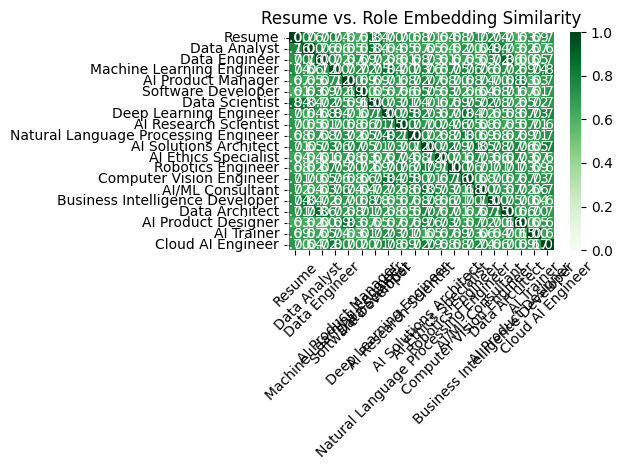

In [14]:
for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    print(model.name)

role_texts = {
    "Data Analyst": "Responsible for analyzing structured and unstructured datasets, performing exploratory data analysis (EDA), generating insights, creating data visualizations, and using SQL, Python, and BI tools (e.g., Tableau, Power BI) to present findings to stakeholders.",
    
    "Data Engineer": "Designs, builds, and maintains data pipelines, ETL (Extract, Transform, Load) processes, and large-scale data infrastructure. Works with big data technologies (e.g., Hadoop, Spark), cloud platforms (AWS, GCP, Azure), and databases (SQL, NoSQL) to ensure the efficient flow and storage of data for analysis.",
    
    "Machine Learning Engineer": "Develops and deploys machine learning models in production environments, focusing on model performance, scalability, and automation. This includes feature engineering, model selection, hyperparameter tuning, and integrating ML models into applications. Familiar with tools like TensorFlow, PyTorch, scikit-learn, and MLOps frameworks.",
    
    "AI Product Manager": "Leads cross-functional teams to define, build, and scale AI-powered products. Involves gathering user feedback, setting product vision, managing product roadmaps, and collaborating with data scientists, engineers, and designers to deliver AI-driven features and solutions. Strong understanding of AI technologies, including LLMs (Large Language Models), and their applications.",
    
    "Software Developer": "Writes and maintains software applications and backend systems, working on both frontend and backend components. Uses modern programming languages (e.g., Python, Java, C++) to develop scalable software solutions, integrate APIs, and work in Agile teams. In AI-related roles, developers may also integrate AI models into applications.",
    
    "Data Scientist": "Uses statistical methods, machine learning, and data analysis techniques to interpret complex datasets and generate actionable insights. Builds predictive models, performs hypothesis testing, and communicates findings to non-technical stakeholders. Proficient in Python, R, SQL, and machine learning frameworks.",
    
    "Deep Learning Engineer": "Specializes in building and deploying deep learning models using neural networks for tasks such as image recognition, natural language processing (NLP), and speech recognition. Works with frameworks like TensorFlow, Keras, PyTorch, and focuses on optimizing model performance in high-complexity scenarios.",
    
    "AI Research Scientist": "Conducts cutting-edge research in artificial intelligence, exploring novel algorithms, theories, and methodologies. Contributes to advancing the state of AI through academic publications and applying new insights to real-world problems. Often involved in the development of new techniques in machine learning, reinforcement learning, and NLP.",
    
    "Natural Language Processing Engineer": "Specializes in enabling machines to understand, interpret, and generate human language. Develops NLP models for tasks like language translation, sentiment analysis, question answering, and named entity recognition (NER). Works with large datasets and state-of-the-art models like transformers and BERT.",
    
    "AI Solutions Architect": "Designs AI systems and solutions tailored to specific business needs. Works with stakeholders to define requirements and builds scalable, reliable AI architectures that integrate machine learning models into business processes. Knowledgeable in cloud computing, APIs, and integration of AI with other enterprise software.",
    
    "AI Ethics Specialist": "Focuses on the ethical implications of AI and machine learning technologies. Ensures that AI systems are developed and deployed responsibly, with attention to fairness, accountability, transparency, and privacy. Works closely with legal and regulatory bodies to ensure compliance with ethical standards in AI practices.",
    
    "Robotics Engineer": "Designs and develops robots or robotic systems, often using AI algorithms to enable autonomous decision-making. Works with hardware and software to integrate machine learning models into robotic applications for industries such as manufacturing, healthcare, and logistics.",
    
    "Computer Vision Engineer": "Specializes in enabling machines to interpret and understand visual information. Works on image processing, object detection, facial recognition, and other computer vision tasks using deep learning algorithms. Proficient in libraries like OpenCV, TensorFlow, and PyTorch.",
    
    "AI/ML Consultant": "Advises organizations on how to implement AI and machine learning strategies to solve business problems. Provides expertise on model selection, deployment, scaling, and integration into business processes. Works with both technical teams and business stakeholders to ensure AI solutions are aligned with organizational goals.",
    
    "Business Intelligence Developer": "Designs and develops BI solutions, such as dashboards and reports, to help organizations make data-driven decisions. Works with data visualization tools (e.g., Tableau, Power BI) and understands the application of AI to augment reporting and business insights.",
    
    "Data Architect": "Designs and manages data structures, ensuring that data is stored efficiently and can be accessed effectively. Works on creating and maintaining data warehouses, databases, and big data systems, while also ensuring that data models are scalable and future-proof for AI and machine learning applications.",
    
    "AI Product Designer": "Focuses on the user experience of AI-powered products, ensuring that the interface, interaction, and usability of AI systems are intuitive and aligned with user needs. Collaborates with product managers and engineers to create seamless user journeys in AI applications, including LLM-based chatbots and recommendation systems.",
    
    "AI Trainer": "Teaches and supports the training of machine learning models by curating high-quality labeled datasets, annotating data, and applying domain-specific knowledge to improve model accuracy. Often involved in reinforcement learning or supervised learning setups.",
    
    "Cloud AI Engineer": "Specializes in deploying AI and machine learning models to the cloud, leveraging cloud platforms (AWS, GCP, Azure) to scale AI applications and make them accessible. Familiar with cloud-native AI tools and services, such as AWS SageMaker, Google AI Platform, and Azure ML."
}


resume_text = "Experienced data science professional with a strong background in data analysis, machine learning, and automation, demonstrated through various roles in financial services and research. Proven ability to drive business growth through data-informed decisions."
texts = [resume_text] + list(role_texts.values())
labels = ["Resume"] + list(role_texts.keys())

response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts,
    config=types.EmbedContentConfig(task_type='semantic_similarity')
)

# Create similarity heatmap
df = pd.DataFrame([e.values for e in response.embeddings], index=labels)
sim = df @ df.T
sns.heatmap(sim, vmin=0, vmax=1, cmap="Greens", annot=True, fmt=".2f")
plt.title("Resume vs. Role Embedding Similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("embedding_match_heatmap.png")
plt.show()

## 🎯 Top Career Matches

I'm filtering the results to focus on just the top 10 roles that match the resume. This gives us a clearer picture of your most promising career paths without the visual clutter of all possible roles.

The color intensity shows how closely your skills align with each role - darker blue means stronger alignment.

/tmp/ipykernel_157/1003166522.py:14: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_157/1003166522.py:15: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from current font.
  plt.savefig("top_embedding_similarity_heatmap.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


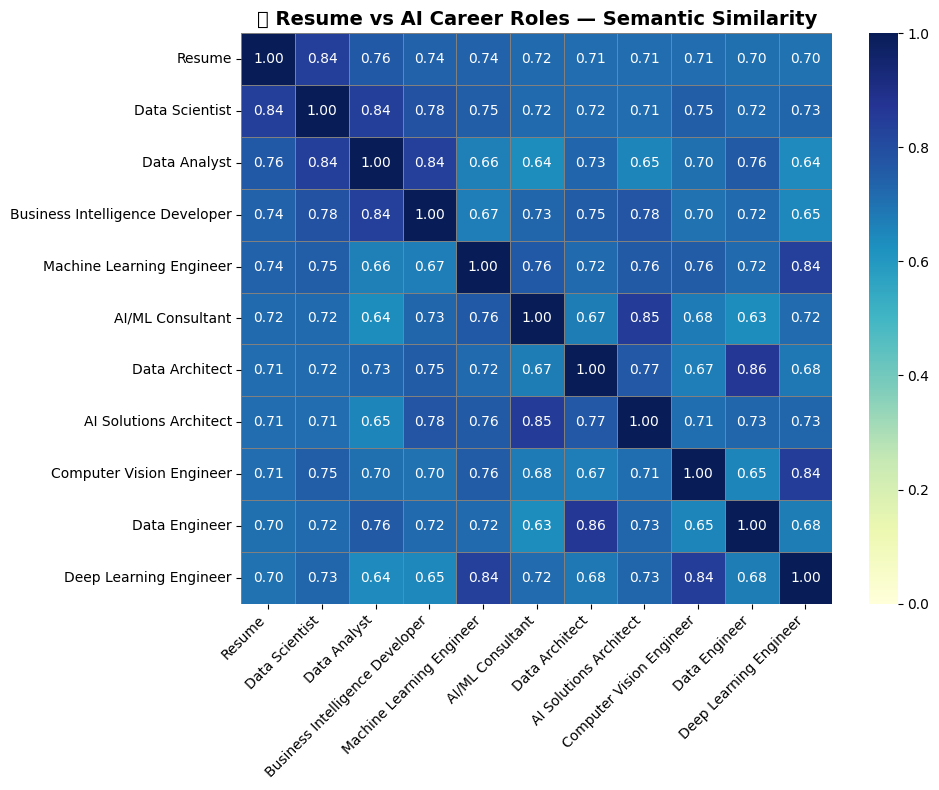

In [15]:
# Get similarity of Resume to each role
resume_sim = sim.iloc[0, 1:]  # skip the diagonal
top_roles = resume_sim.sort_values(ascending=False).head(10)

# Filter top 10 similar roles for cleaner view
filtered_labels = ["Resume"] + list(top_roles.index)
filtered_sim = sim.loc[filtered_labels, filtered_labels]

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_sim, vmin=0, vmax=1, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("💼 Resume vs AI Career Roles — Semantic Similarity", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("top_embedding_similarity_heatmap.png")
plt.show()


In [16]:
top_match = top_roles.idxmax()
top_score = top_roles.max()

print(f"✅ Your resume is most similar to: **{top_match}** with a score of **{top_score:.2f}**")
print("🔍 Consider tailoring your resume further for this role or exploring job openings in this path.")


target_role = top_roles.idxmax()
career_scorecard['target_role_recommended']=target_role
target_role

✅ Your resume is most similar to: **Data Scientist** with a score of **0.84**
🔍 Consider tailoring your resume further for this role or exploring job openings in this path.


'Data Scientist'

## 🌐 Real-Time Job Search with SERP API

To ensure the resume evaluation aligns with *real-world opportunities*, I integrated a live job search step using the [SerpAPI](https://serpapi.com/), which scrapes job boards like **greenhouse.io** and **lever.co**.

Here’s how it works:

- I securely fetched the SerpAPI key using Kaggle Secrets to avoid exposing credentials.
- The code dynamically searches for jobs based on:
  - Your **target role** (e.g., “Data Scientist”)
  - Your **location** extracted from the resume
- Top 5 job listings are parsed with titles, links, and snippets to build a real-time matching database.
- These jobs are then used to ground the rest of the evaluation, ensuring the system doesn’t just critique your resume in isolation — it connects it to real hiring trends.

This step powers:
- The **Job-Relevance Matching Score**
- The **Skill Gap Detection**
- And gives users real job links they can apply to right away.

🚀 *This makes ResuMeme.AI more than just a resume checker — it’s a full-stack job readiness evaluator.*


In [17]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

from serpapi import GoogleSearch
import os
Serp_api_key = user_secrets.get_secret("SERPAPI_KEY")
def search_real_job_links(role="Data Scientist", location="Austin, TX"):
    params = {
        "engine": "google",
        "q": f'site:greenhouse.io OR site:lever.co "{role}" "{location}"',
        "location": location,
        "hl": "en",
        "gl": "us",
        "api_key": Serp_api_key
    }

    search = GoogleSearch(params)
    results = search.get_dict()

    jobs = []
    for result in results.get("organic_results", []):
        if "title" in result and "link" in result:
            jobs.append({
                "title": result["title"],
                "link": result["link"],
                "snippet": result.get("snippet", "")
            })

    return jobs

jobs = search_real_job_links(target_role,career_scorecard['resume_entity_mapped']['location'])
job_links = []
# print(jobs)
for job in jobs[:5]:
    print("✅", job.get("title"), "-", job.get("company_name"))
    print("Link:", job.get("link", "N/A"))
    print("="*80)
    job_links.append(job)


✅ Senior Data Scientist - Austin, Texas, United States - None
Link: https://boards.greenhouse.io/roku/jobs/6726915
✅ Job Application for Data Scientist at Base Power Company - None
Link: https://job-boards.greenhouse.io/basepowercompany/jobs/4551163008
✅ Jobs at IntegraFEC - None
Link: https://boards.greenhouse.io/integra
✅ Job Application for Data Scientist at YETI Test Events Job Board - None
Link: https://job-boards.greenhouse.io/yetitestevents/jobs/4001110004
✅ Jobs at IntegraFEC - Internships - None
Link: https://job-boards.greenhouse.io/integrainterns/jobs/4522535008


## 🔍 Job Page Scraping with Gemini + BeautifulSoup

Once I’ve retrieved live job links, I take it one step further: **scraping each job page** to extract structured data like required skills, job description, company, and location — even when the HTML is messy.

Here’s how I made that happen:

- Fetched the full HTML of each job posting using `requests`
- Parsed and cleaned the page using `BeautifulSoup` to strip away styling, scripts, and noise
- Sent the cleaned text to **Gemini Flash 2.0** using structured JSON prompting to extract:
  - 🎯 `title`
  - 🧠 `required_skills`
  - 🧾 `job_description`
  - 🏢 `company_name`
  - 📍 `location`
  - ⏱️ `employment_type`

 🔎 Example: Roku – Senior Data Scientist

```json
{
  "company_name": "Roku",
  "title": "Senior Data Scientist",
  "location": "Austin, Texas, United States",
  "employment_type": "Full-time",
  "required_skills": [
    "SQL",
    "Python",
    "R",
    "Tableau",
    "Looker",
    "Statistics",
    "A/B testing",
    "data visualization"
  ],
  "job_description": "As a Senior Data Scientist, you will leverage Big Data to generate insights that fuel Roku’s most significant business decisions. You’ll combine technical skills, business intuition, and communication to proactively identify high-impact opportunities and present actionable recommendations."
}

In [18]:
class ScrapedJobDetails(typing.TypedDict):
    company_name: str
    title: str
    required_skills: list[str]
    job_description: str
    location: str
    employment_type: str

def get_job_details_gemini(job):
    html = requests.get(job["link"]).text
    soup = BeautifulSoup(html, "html.parser")
    cleaned_text = soup.get_text()
    
    prompt = f"""Extract job details from the following page content:{cleaned_text} in JSON format"""
    
    job_response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(
            temperature=0.4,
            response_mime_type="application/json",
            response_schema=ScrapedJobDetails
        ),
         contents=prompt
    )
    return job_response

In [19]:
all_jobs=[]
for i in job_links:
    job_response = get_job_details_gemini(i)
    parsed_data = job_response.candidates[0].content.parts[0].text
    
    job_data = json.loads(parsed_data)
    
    doc = f"""Company Name: {job_data.get("company_name", "")}
        Title: {job_data.get("title", "")}
        Location: {job_data.get("location", "")}
        Employment Type: {job_data.get("employment_type", "")}
        
        Required Skills:
        - {','.join(job_data.get('required_skills', [])) or 'N/A'}
        
        Job Description:
        {job_data.get("job_description", "")}"""
    
    all_jobs.append(doc)

print(f'{len(all_jobs)} jobs retrieved\n')
print(all_jobs)


5 jobs retrieved

['Company Name: Roku\n        Title: Senior Data Scientist\n        Location: Austin, Texas, United States\n        Employment Type: Full-time\n        \n        Required Skills:\n        - SQL,Python,R,Tableau,Looker,Statistics,A/B testing,Data visualization\n        \n        Job Description:\n        As a Senior Data Scientists you will leverage Big Data to generate insights that fuel Roku’s most significant business decisions. As a Senior Data Scientist, you will also use a combination of technical skills, business intuition, and analytical thinking to partner with business leaders and provide actionable recommendations. Senior Data Scientists at Roku are thought partners to executive business leaders, so communication and presentation are enormously important. Senior Data Scientists do not take direction from business owners and execute ad-hoc questions. You will proactively identify the areas of the data and business that require attention and formulate analyses

In [20]:
# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]


import chromadb

DB_NAME = "googlejobsdb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)
# documents = [job_1, job_2, job_3,job_4]
documents=all_jobs

### Step 5: Store all the retrieved jobs in Chroma DBl_jobs
db.add(documents=documents, ids=[str(i) for i in range(len(documents))])
db.count

<bound method Collection.count of Collection(name=googlejobsdb)>

In [21]:
# Define the schema
class JobEntry(typing.TypedDict):
    title: str
    match_percentage: int
    skills_present: list[str]
    skills_missing: list[str]
    match_analysis: str
    improvement_suggestions: list[str]

class JobMatchResponse(typing.TypedDict):
    jobs: list[JobEntry]
    overall_recommendation: str

embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "Show me the closest job matches for my resume"

result = db.query(query_texts=[query], n_results=5)
[all_passages] = result["documents"]

all_passages

query_oneline = query.replace("\n", " ")

job_match_prompt = f"""
    Given a question by job seeker : {query_oneline} and the resume {resume_text}
    Generate a detailed analysis of how well this candidate's resume matches each Google job. For each job:
    1. Calculate a match percentage (0-100%) based on alignment of skills, experience, location, and education
    2. Identify skills from the job that are present in the resume
    3. Identify important skills from the job that are missing in the resume
    4. Explain why this role might be a good or poor fit
    5. Suggest specific improvements to make the resume more competitive
    
    Format your response as JSON:
    {{
      "jobs": [
        {{
          "title": "Job title",
          "match_percentage": number,
          "skills_present": ["skill1", "skill2"...],
          "skills_missing": ["skill1", "skill2"...],
          "match_analysis": "analysis of fit",
          "improvement_suggestions": ["suggestion1", "suggestion2"...]
        }},
        ...
      ],
      "overall_recommendation": "overall career advice"
    }}
    """


# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", " ")
    job_match_prompt += f"PASSAGE: {passage_oneline}\n"


# Now call the model
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=job_match_prompt,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=JobMatchResponse
    )
)


Markdown(answer.text)
data = answer.text
print(data)

{
  "jobs": [
    {
      "title": "Data Scientist (YETI Test Events Job Board)",
      "match_percentage": 75,
      "skills_present": [
        "AI/ML",
        "Data Modeling",
        "Python",
        "R",
        "Matlab",
        "Hadoop",
        "Hive",
        "Spark",
        "Tableau",
        "PowerBI",
        "data science"
      ],
      "skills_missing": [
        "AWS Lambda"
      ],
      "match_analysis": "This role is a strong fit for the candidate. The resume demonstrates significant experience in data analysis, machine learning, and the required tools (Python, R, etc.). The candidate also has experience with big data technologies like Hadoop and Spark. The role emphasizes translating business requirements into data solutions, which aligns with the candidate's ability to drive business growth through data-informed decisions.",
      "improvement_suggestions": [
        "Quantify achievements with specific metrics to showcase the impact of data-informed decisions.

/tmp/ipykernel_157/2130665715.py:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


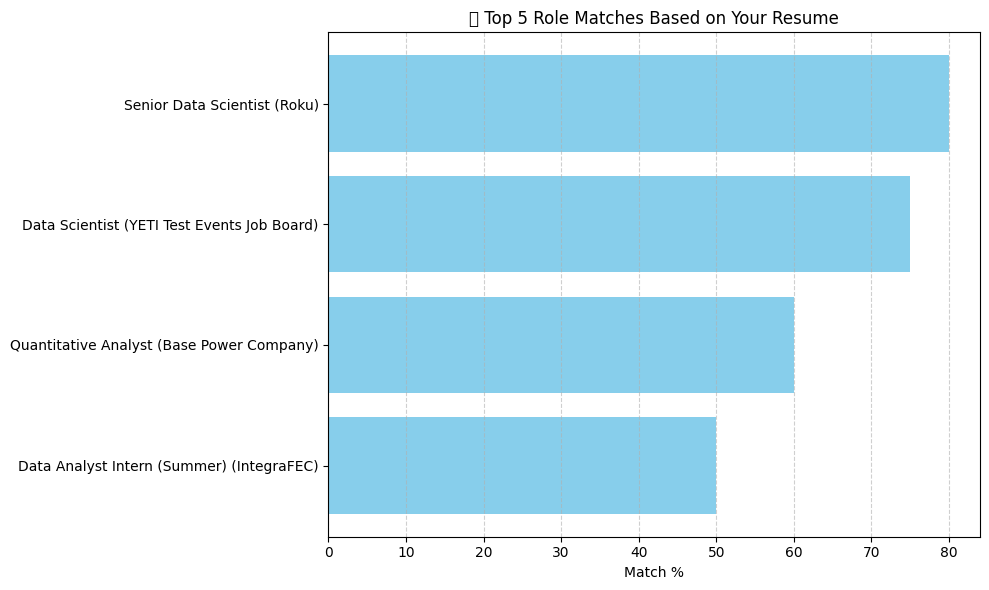

In [22]:
import matplotlib.pyplot as plt
parsed_data = json.loads(data)
top_roles = sorted(parsed_data["jobs"], key=lambda x: -x["match_percentage"])[:5]
titles = [job["title"] for job in top_roles]
scores = [job["match_percentage"] for job in top_roles]

plt.figure(figsize=(10, 6))
plt.barh(titles, scores, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Match %")
plt.title("🔍 Top 5 Role Matches Based on Your Resume")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [23]:
df = pd.DataFrame(top_roles)
career_scorecard['job_match_details']=df
display(df)



,title,match_percentage,skills_present,skills_missing,match_analysis,improvement_suggestions
0,Senior Data Scientist (Roku),80,"[SQL, Python, R, Tableau, Data visualization, ...",[Looker],This role is a strong fit. The candidate's res...,[Provide specific examples of data visualizati...
1,Data Scientist (YETI Test Events Job Board),75,"[AI/ML, Data Modeling, Python, R, Matlab, Hado...",[AWS Lambda],This role is a strong fit for the candidate. T...,[Quantify achievements with specific metrics t...
2,Quantitative Analyst (Base Power Company),60,"[Mathematics, Physics, Engineering, Python, da...","[SQL, risk management]",The candidate's background aligns well with th...,"[Highlight experience with SQL if available., ..."
3,Data Analyst Intern (Summer) (IntegraFEC),50,"[Data Analysis, data science]",[],The candidate has more experience than an inte...,[Focus on more senior-level data science roles...


# Final Career Report : Display the final generated Career Report

In [24]:
career_scorecard

{'zero_shot_feedback': 'Okay, I\'ve reviewed your resume. It has strong content demonstrating your skills and experience, but it needs significant formatting and structural improvements to be more effective and ATS-friendly. Here\'s a breakdown of the errors and a revised version with explanations:\n\n**General Errors and Improvements Needed:**\n\n*   **Formatting:** The resume is riddled with inconsistent spacing, unusual character usage, and poor formatting choices. This makes it visually unappealing and difficult to read.\n*   **ATS Compatibility:** The unusual spacing and formatting will likely cause problems with Applicant Tracking Systems (ATS). ATS are used by most companies to scan resumes, and if your resume isn\'t formatted correctly, it might be rejected automatically.\n*   **Clarity and Conciseness:** Some descriptions are wordy and could be more impactful by using stronger action verbs and quantifying accomplishments.\n*   **Chronological Order:** Ensure all experiences ar

In [27]:
from weasyprint import HTML
from IPython.display import HTML as ipyHTML

def bullet_list(items):
    if not items or not isinstance(items, list) or len(items) == 0:
        return "<p>No items available</p>"
    return "<ul>" + "".join(f"<li>{i}</li>" for i in items) + "</ul>"

def section(title, content):
    if isinstance(content, list):
        content_html = bullet_list(content)
    else:
        content_html = f"<p>{content}</p>"
    return f"<h2>{title}</h2>{content_html}"

def generate_career_scorecard(resume):
    """Generate HTML and PDF career scorecard"""
    
    job_df = resume['job_match_details']
    
    # ----- HTML Structure -----
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
      <meta charset="utf-8">
      <style>
        body {{
          font-family: 'Arial', sans-serif;
          margin: 30px;
          color: #222;
          line-height: 1.6;
        }}
        h1 {{ font-size: 28px; margin-bottom: 10px; }}
        h2 {{ font-size: 20px; margin-top: 30px; }}
        h3 {{ font-size: 18px; margin-top: 20px; }}
        h4 {{ font-size: 16px; margin-top: 15px; margin-bottom: 5px; }}
        table {{
          width: 100%;
          border-collapse: collapse;
          margin-top: 10px;
        }}
        th, td {{
          border: 1px solid #999;
          padding: 8px;
          font-size: 12px;
          text-align: left;
          vertical-align: top;
        }}
        th {{
          background-color: #444;
          color: #fff;
        }}
        ul {{ margin: 0; padding-left: 20px; }}
        li {{ margin-bottom: 5px; }}
        .footer {{ margin-top: 50px; font-size: 14px; color: #555; }}
        .score-box {{
          display: inline-block;
          padding: 5px 15px;
          background-color: #f0f0f0;
          border-radius: 5px;
          font-weight: bold;
          margin-right: 10px;
        }}
        .section-score {{
          float: right;
          font-weight: bold;
        }}
        .ats-verdict {{
          display: inline-block;
          padding: 5px 10px;
          border-radius: 5px;
          font-weight: bold;
          margin-bottom: 10px;
        }}
        .ats-fail {{
          background-color: #ffcccc;
          color: #cc0000;
        }}
        .ats-needs-improvement {{
          background-color: #fff2cc;
          color: #b38600;
        }}
        .match-percentage {{
          font-weight: bold;
        }}
        .match-high {{
          color: #008800;
        }}
        .match-medium {{
          color: #b38600;
        }}
        .match-low {{
          color: #cc0000;
        }}
      </style>
    </head>
    <body>
    <h1>🚀 Career Summary Card</h1>
    <p><b>Generated Role Recommendation:</b> <span style="font-size: 16px;">📌 {resume['target_role_recommended']}</span></p>
    """

    # Resume Score Section
    html += f"""
    <h2>🎯 Resume Score</h2>
    <p><b>Overall Score:</b> <span class="score-box">{resume['resume_feedback']['overall_score']} / 10</span></p>
    """

    # Section Scores
    html += "<h2>📊 Section Scores</h2>"
    
    # Add each section score and feedback
    for section_name in ['summary', 'experience', 'skills', 'tools', 'projects']:
        if section_name in resume['resume_feedback']:
            section_data = resume['resume_feedback'][section_name]
            html += f"""
            <div>
              <h3>{section_name.capitalize()} <span class="section-score">{section_data['score']} / 10</span></h3>
              <h4>Feedback:</h4>
              {bullet_list(section_data['feedback'])}
              <h4>Recommended Updates:</h4>
              {bullet_list(section_data['updates'])}
            </div>
            """
    
    # ATS Feedback
    html += "<h2>🛠 ATS Compliance</h2>"
    for ats_feedback in resume['ATS_Feedback']:
        verdict_class = "ats-needs-improvement" if ats_feedback['verdict'] == "Needs Improvement" else "ats-fail"
        html += f"""
        <div>
          <div class="ats-verdict {verdict_class}">Verdict: {ats_feedback['verdict']}</div>
          <h3>Visual Issues:</h3>
          {bullet_list(ats_feedback['visual_issues'])}
        </div>
        """
    
    # Entity Mapped
    html += "<h2>📍 Resume Entity Mapping</h2><ul>"
    entities = resume['resume_entity_mapped']
    for key, val in entities.items():
        if isinstance(val, list):
            val_text = ", ".join(val)
        else:
            val_text = str(val)
        html += f"<li><b>{key.capitalize()}:</b> {val_text}</li>"
    html += "</ul>"
    
    # Job Match Table
    html += """
    <h2>💼 Job Match Summary</h2>
    <table>
      <tr>
        <th>Title</th>
        <th>Match %</th>
        <th>Skills Present</th>
        <th>Skills Missing</th>
        <th>Match Analysis</th>
      </tr>
    """
    
    # Loop through job matches - using direct indexing based on your sample data structure
    for idx in range(len(job_df['title'])):
        job_title = job_df['title'][idx]
        match_percent = job_df['match_percentage'][idx]
        
        # Handle skills present as either list or string
        skills_present = job_df['skills_present'][idx]
        if isinstance(skills_present, list):
            skills_present_text = ", ".join(skills_present)
        else:
            skills_present_text = str(skills_present)
            
        # Handle skills missing as either list or string
        skills_missing = job_df['skills_missing'][idx]
        if isinstance(skills_missing, list):
            skills_missing_text = ", ".join(skills_missing)
        else:
            skills_missing_text = str(skills_missing)
            
        match_analysis = job_df['match_analysis'][idx]
        
        # Determine color class based on match percentage
        if match_percent >= 70:
            match_class = "match-high"
        elif match_percent >= 40:
            match_class = "match-medium"
        else:
            match_class = "match-low"
            
        html += f"""
        <tr>
          <td>{job_title}</td>
          <td class="match-percentage {match_class}">{match_percent}%</td>
          <td>{skills_present_text[:200]}</td>
          <td>{skills_missing_text[:150]}</td>
          <td>{match_analysis[:200]}...</td>
        </tr>
        """
    
    html += """
    </table>
    <p class="footer">✅ Generated using Python on Kaggle 💻</p>
    </body>
    </html>
    """
    
    # Write HTML and PDF
    with open("career_summary.html", "w", encoding="utf-8") as f:
        f.write(html)
    
    HTML("career_summary.html").write_pdf("career_summary.pdf")
    print(f"The Career Score Card is generated and stored at /kaggle/working/career_summary.html")
    return html

# Usage example:
html_output = generate_career_scorecard(career_scorecard)

display(ipyHTML(open('career_summary.html').read()))

The Career Score Card is generated and stored at /kaggle/working/career_summary.html


Title,Match %,Skills Present,Skills Missing,Match Analysis
Senior Data Scientist (Roku),80%,"SQL, Python, R, Tableau, Data visualization, Statistics, A/B testing",Looker,"This role is a strong fit. The candidate's resume demonstrates proficiency in the required technical skills (SQL, Python, R, Tableau), as well as experience in data visualization and statistical analy..."
Data Scientist (YETI Test Events Job Board),75%,"AI/ML, Data Modeling, Python, R, Matlab, Hadoop, Hive, Spark, Tableau, PowerBI, data science",AWS Lambda,"This role is a strong fit for the candidate. The resume demonstrates significant experience in data analysis, machine learning, and the required tools (Python, R, etc.). The candidate also has experie..."
Quantitative Analyst (Base Power Company),60%,"Mathematics, Physics, Engineering, Python, data science, statistical background, modeling","SQL, risk management","The candidate's background aligns well with the quantitative and analytical aspects of this role. The resume indicates a strong foundation in data analysis and machine learning, which are valuable for..."
Data Analyst Intern (Summer) (IntegraFEC),50%,"Data Analysis, data science",,"The candidate has more experience than an internship would require. While the resume clearly showcases data analysis skills, this role might be too junior for someone with an experienced data science ..."


## 🤪 Resume Meme Generator (Because Feedback Should Be Fun)

Yes, this is a **resume critic** that roasts you gently. To lighten the mood, I added a Meme Generator powered by **Gemini Flash + Image Gen**, built directly on top of your `career_scorecard`.

Here’s what happens:

---

### 🎭 Step 1: Generate the Meme Idea

I prompt Gemini with this:

> “Based on the resume feedback, generate a funny, sassy, positive meme.  
> It should be clever, universally funny, and safe-for-work.  
> Output should follow this schema:  
> - `meme_text`: caption  
> - `meme_image`: image idea”

Example output:

```json
{
  "meme_text": "When your resume says 'dynamic' but your layout says '1999 WordArt'",
  "meme_image": "A confused cat sitting at a typewriter surrounded by glittery Microsoft Word clipart"
}

In [38]:
class MemeFormat(typing.TypedDict):
    meme_text: str
    meme_image: str

meme_prompt = f"""
Based on the {career_scorecard} generate a funny, sassy, positive meme. It should be one meme that is
Universally funny
Easy to understand
Sassy but safe
No sensitive or controversial topics
Cleverly echoes resume issues. 

generate text and meme image idea separately
follow the JSON
"""
meme_text = None
answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=meme_prompt,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=MemeFormat
    )
)

meme_response = answer.candidates[0].content.parts
parsed = json.loads(meme_response[0].text)

meme_text = parsed["meme_text"]
meme_image = parsed["meme_image"]

print("📝 Meme Text:", meme_text)
print("\n🖼️ Meme Image Prompt:", meme_image)

📝 Meme Text: My resume before revisions: 'I put the 'fun' in dysfunctional formatting!'
My resume after revisions: 'I put the 'hire' in higher chances of getting the job!'

🖼️ Meme Image Prompt: Image: Drakeposting meme.
Drake looking displeased at a resume with inconsistent formatting, weird fonts, and a 'Skills & Interests' section.
Drake looking approvingly at a clean, ATS-friendly resume with quantifiable achievements and a skills section tailored to the job.


## 🎨 Meme Image Rendering with Gemini Image Model

Once I receive the meme idea from Gemini (caption + visual description), I pass just the image prompt into **Gemini's image generation endpoint** using the `gemini-2.0-flash-exp-image-generation` model.

This step generates a high-quality meme-style image based on the description — using a multimodal configuration that returns both image and optional text.

---

### 🛠️ How It Works:
- Gemini receives the `meme_image` prompt
- It returns:
  - Optional **commentary text** (sometimes witty, sometimes dry)
  - A **generated meme image**
- The image is rendered directly in the notebook using `PIL` and `BytesIO`
- The meme caption (`meme_text`) is then displayed underneath for context

> ⚠


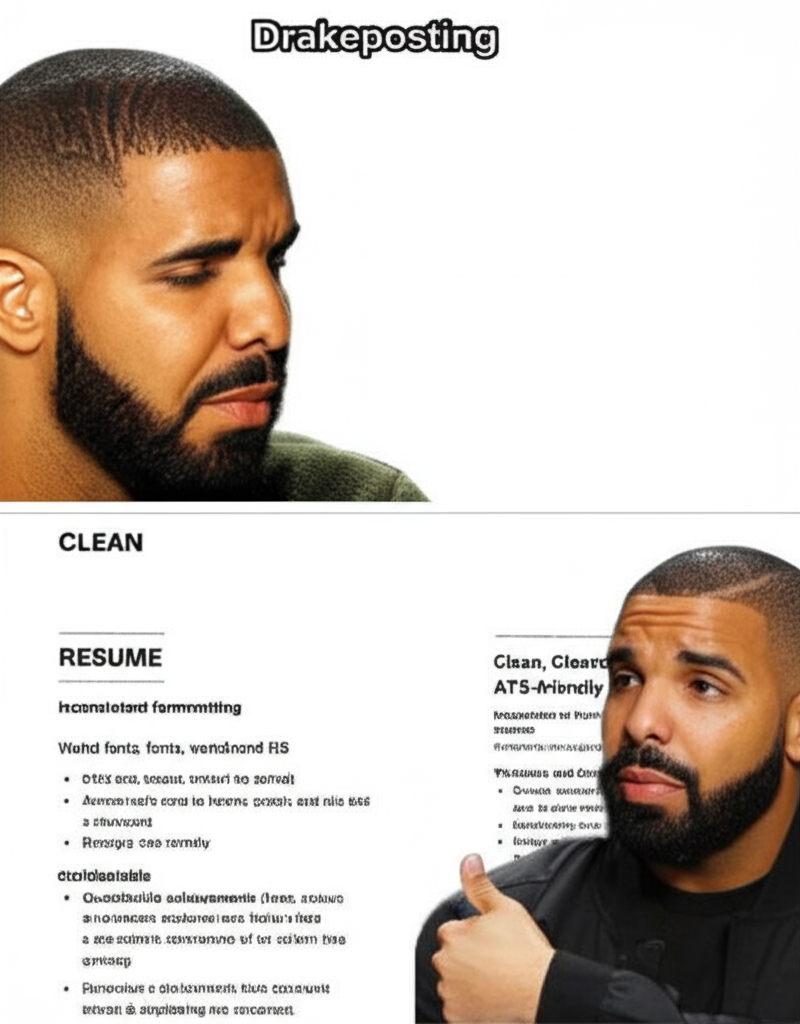

### My resume before revisions: 'I put the 'fun' in dysfunctional formatting!'
My resume after revisions: 'I put the 'hire' in higher chances of getting the job!'

In [39]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO


response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=(meme_image),
    config=types.GenerateContentConfig(
      response_modalities=['TEXT', 'IMAGE']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image = Image.open(BytesIO((part.inline_data.data)))
    image.save('gemini-meme-image.png')
    # image.show()
    display(image)
    display(Markdown(f"### {meme_text}"))


## 🗣️ “Tell Me About Yourself” Generator

To help users prepare for interviews, I used Gemini to generate a personalized **“Tell me about yourself”** response based on the resume data and job alignment insights.

This is not a generic blurb — it’s grounded in your:
- Resume content
- CareerScorecard feedback
- Skills and experience relevance

Each response is structured, human-sounding, and job-targeted — ideal for using as an elevator pitch, LinkedIn headline, or mock interview intro.

> ⚠️ The output will vary across different runs based on slight differences in resume input, target job, and language randomness.

---

📌 *Built to give you confidence when you’re asked the one question everyone dreads.*

In [ ]:
intro_prompt = f"""
You are a career mentor helping a job candidate prepare for interviews. Based on the resume information provided below, craft a compelling 2-minute response to the common interview question "Tell me about yourself."

The response should:
1. Start with a brief professional introduction (current role/background)
2. Highlight 2-3 key accomplishments with specific metrics from the resume
3. Emphasize relevant skills aligned with the target role (Data Scientist/ML Engineer)
4. Include a brief explanation of why the candidate is interested in this field/role
5. End with a concise statement about career goals
6. Be conversational in tone, as if the candidate is speaking naturally
7. Be approximately 2 minutes when spoken aloud (roughly 250-300 words)
8. ONLY use information contained in the resume data - do not fabricate experience, skills, or qualifications

Resume data:
{resume_text}
"""

intro_response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=intro_prompt,
)
intro_response_text = intro_response.text
Markdown(intro_response_text)

---

## 🧑‍💻 Author & Creator

This project was designed, built, and written by **Anupama Garani** .

I created **ResuMeme.AI** as a solo developer, using a mix of AI-assisted coding, product thinking, and good old debugging.  
From scraping job listings to analyzing resume layout with Gemini Vision, everything was built intentionally to give job-seekers real, actionable feedback — with a side of sass.

---

### 💡 Why I Built This

Because most resume tools are boring.  
Because real feedback shouldn’t hide behind a paywall.  
Because job search deserves both precision and personality.

---

### 🔧 Tech Stack Highlights:
- Gemini Flash 2.0 (text + image)
- Gemini Vision layout evaluation
- ChromaDB for skill retrieval
- SerpAPI for job scraping
- Python (LangChain, PIL, WeasyPrint, BeautifulSoup)

---

🎯 **What You Get**:
- Smart resume evaluation
- Real job matches
- AI-powered interview prep
- And a meme to roast yourself, just a little

If this project helped you fix your resume, land a job, or just laugh at your layout — that’s a win.

Thanks for using ResuMeme.AI 💛  
*Built with care, code, and a lot of curiosity.*

---
